# Shape generation with a Reinforcement Learning agent

This notebook is an experiment with shape generation using fonts as datasets. (0-9 a-z A-Z)<br>
The agent's start point is a random pixel on a random* letter/digit of the dataset. The initial state is a single 1 in the middle of a 25x25 grid. The agent explores the unknown world and will fail a lot since it doesn't know which letter it's exploring.

The state is being fed through a neural network that outputs a probability matrix for the next action. <br>
An action constitutes of picking a pixel adjacent to the current state. <br>
The agent picks the action with the highest probability. <br>
If that pixel is a part of the letter, the action and input state is added to a list, the success streak. <br>
The states and actions of the success streak is used to update the Q-value network <br>
Since the states and actions of the streak will be fed through the network for every new successful action, long streaks are extra rewarded. <br>
The new pixel is added to the agents 25X25 scope of view and the grid is re-positioned so the new point is centered. <br>
If the agent picks a bad action, the success streak is over and the agent will continue with the next likely action. <br>

During shape generation the agent is no longer restricted by the training example. It can move freely, but will use the tactics learned during training.

There is a second neural network that predicts the probability of the agent's next move being a good move. Generally, the best action is chosen during generation, but to be able to generate different results, some randomness is needed. The action will be chosen from a random distribution when the probability network outputs a low result. If the outcome of the next action is uncertain, we might as well try a random action.

Examples from the dataset on top, generated shapes below. Not fantastic results, but something...

![ ](dataset_generated.PNG)
<br>

'*' try a structured starting point using extremum


In [265]:
import os
os.chdir("/home/johan_lagerloef")

In [211]:
from PIL import Image
import numpy as np
import os

def load_image( infilename ):
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

path = '/datasets/Cone'
flist=[]

for filename in os.listdir(path):
    #print(path+"/"+filename)
    flist.append(load_image(path+"/"+filename))
    
#TODO: use pickle files instead

random_i: 38
pixels: 67


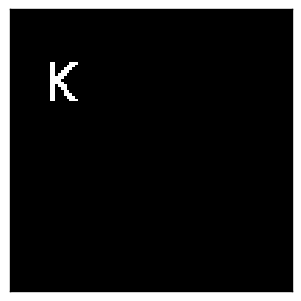

In [264]:
x_all=np.array(flist)
x_all=np.delete(x_all,[1,2],axis=3)

def set_example(i):
    ex=x_all[i]/255*-1+1
    ex=(ex>0.3)*1
    return ex

num_examples=62

fi=np.random.randint(num_examples)
x_inp=set_example(fi)

print("random_i: "+str(fi))
print("pixels: "+str(np.count_nonzero(x_inp)))

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 8))
ax = plt.subplot(2, 1, 1)
plt.imshow(x_inp.reshape(100,100), interpolation="nearest")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [214]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K
import tensorflow as tf

def valueNetwork(x):
    inp_size=ws*ws
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    p = Dense(inp_size, activation='softmax')(x)  
    return p

def predict_model(x):
    inp_size=ws*ws
    x = Dense(128, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    #x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    p = Dense(1, activation='sigmoid')(x)  
    return p

In [215]:
def outline(s_in):
    s=np.pad(s_in,1,'constant')
    s_0=np.roll(s,-1,axis=0)
    s_1=np.roll(s,-1,axis=1)
    s10=np.roll(s,1,axis=0)
    s11=np.roll(s,1,axis=1)
    
    o=s_0+s_1+s10+s11
    o=(o[1:-1,1:-1]>0)*(-s_in+1)
    return o
    
t=np.zeros((4,4))
t[2,1]=1
t[2,2]=1
t[1,2]=1
print(outline(t))

[[ 0.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  1.  1.  0.]]


In [216]:


#window size, agents scope of view
ws=25             
wl=np.floor(ws/2)
wu=np.ceil(ws/2)


tf.reset_default_graph()

state = tf.placeholder(tf.float32, shape=(None,ws*ws))
Y = tf.placeholder(tf.float32, shape=(None,ws*ws))

model=valueNetwork(state)
loss = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(model), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
update = optimizer.minimize(loss)

PY = tf.placeholder(tf.float32, shape=(None,1))
pmodel=predict_model(state)
ploss = tf.nn.sigmoid_cross_entropy_with_logits(labels=PY,logits=pmodel)
poptimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)
pupdate = poptimizer.minimize(ploss)



In [227]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

loss_acc=0.0

for i in range(10000):
    fi=np.random.randint(num_examples)
    x_inp=set_example(fi)
    
    startpoint=[np.random.randint(48),np.random.randint(48)] 

    while x_inp[startpoint[0],startpoint[1]]==0:
        startpoint=[np.random.randint(48),np.random.randint(48)]
    tx,ty=startpoint[0],startpoint[1]

    #Initialize canvas
    canvas=np.zeros((200,200))
    px=100
    py=100
    canvas[px,py]=1

    a_check=0.0
    hits=0
    miss=0
    streak=0
    streaks=[]
    states=[]
    rewards=[]
    
    wrong=np.zeros(ws*ws)
    
    ex_iter=48
    for j in range(ex_iter):

        s=canvas[px-wl:px+wu,py-wl:py+wu].reshape(1,ws*ws)
        
        p=sess.run(model, {state:s}).reshape(ws*ws)
        p_masked=(p.reshape(ws,ws)*outline(s.reshape(ws,ws))).reshape(ws*ws)

        p_masked=p_masked*(-wrong+1)
        p_norm=p_masked/np.sum(p_masked)

        action = np.random.choice(ws*ws,p=p_norm)

        action_oh = np.eye(ws*ws)[action]


        test=x_inp[tx-wl:tx+wu,ty-wl:ty+wu].reshape(ws*ws)

        reward=test*action_oh
        wrong+=((-test+1)>0)*(action_oh>0)
        wrong=(wrong>0)*1

        
        if np.max(reward)==1:
            
            _,lossout = sess.run([pupdate,ploss] , {state:s, PY:np.ones((1,1))})
            
            hits+=1
            streak+=1
            s=s.reshape(ws*ws)
            states.append(s)
            rewards.append(reward.reshape(ws*ws))
    
            sess.run(update, {state:np.array(states), Y:np.array(rewards)})
  
            ux=action//ws-wl
            uy=action%ws-wl  
            px+=ux
            py+=uy
            tx+=ux
            ty+=uy
            canvas[px,py]=1
            wrong=np.zeros(ws*ws)
            
        if np.max(reward)==0:
            _,lossout = sess.run([pupdate,ploss] , {state:s, PY:np.zeros((1,1))})
            
            miss+=1
            streaks.append(streak)
            streak=0
            states=[]
            rewards=[]
            
        loss_acc+=lossout

    streaks.append(streak)
    if (i+1) % 50 == 0:
        print("iteration: "+str(i+1)+" loss: "+str(loss_acc))
        loss_acc=0

saver = tf.train.Saver()
save_path = saver.save(sess, "model.ckpt")
print("Model saved in path: %s" % save_path)


/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


iteration: 50 loss: [[ 1679.76342773]]
iteration: 100 loss: [[ 1589.77758789]]
iteration: 150 loss: [[ 1522.60925293]]
iteration: 200 loss: [[ 1474.53625488]]
iteration: 250 loss: [[ 1477.39660645]]
iteration: 300 loss: [[ 1409.64001465]]
iteration: 350 loss: [[ 1373.12915039]]
iteration: 400 loss: [[ 1374.84887695]]
iteration: 450 loss: [[ 1367.06384277]]
iteration: 500 loss: [[ 1358.8104248]]
iteration: 550 loss: [[ 1337.48840332]]
iteration: 600 loss: [[ 1347.29089355]]
iteration: 650 loss: [[ 1351.72229004]]
iteration: 700 loss: [[ 1331.73046875]]
iteration: 750 loss: [[ 1311.94372559]]
iteration: 800 loss: [[ 1338.51660156]]
iteration: 850 loss: [[ 1382.31274414]]
iteration: 900 loss: [[ 1363.12902832]]
iteration: 950 loss: [[ 1346.31237793]]
iteration: 1000 loss: [[ 1317.92675781]]
iteration: 1050 loss: [[ 1276.52722168]]
iteration: 1100 loss: [[ 1330.06994629]]
iteration: 1150 loss: [[ 1313.15905762]]
iteration: 1200 loss: [[ 1302.88598633]]
iteration: 1250 loss: [[ 1256.7136230

In [224]:
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()
saver.restore(sess, "model.ckpt")

INFO:tensorflow:Restoring parameters from /tf_models/10000/cone.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /tf_models/10000/cone.ckpt: Not found: /tf_models/10000
	 [[Node: save_2/RestoreV2_19 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_2/Const_0_0, save_2/RestoreV2_19/tensor_names, save_2/RestoreV2_19/shape_and_slices)]]

Caused by op 'save_2/RestoreV2_19', defined at:
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-224-654e698488f8>", line 6, in <module>
    saver = tf.train.Saver()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on /tf_models/10000/cone.ckpt: Not found: /tf_models/10000
	 [[Node: save_2/RestoreV2_19 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_2/Const_0_0, save_2/RestoreV2_19/tensor_names, save_2/RestoreV2_19/shape_and_slices)]]


/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
/home/johan_lagerloef/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Random actions: 15Iterations: 61


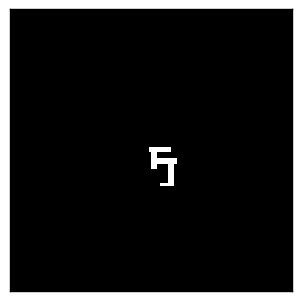

In [254]:
canvas=np.zeros((100,100))
px=py=50
canvas[px,py]=1
ra=0
j=0
while j<100:
    j+=1
    s=canvas[px-wl:px+wu,py-wl:py+wu].reshape(1,ws*ws)
    p=sess.run(model, {state:s}).reshape(ws*ws)
    p=(p.reshape(ws,ws)*outline(s.reshape(ws,ws))).reshape(ws*ws)
    p=p/np.sum(p)
    action = np.argmax(p)
    
    ps=sess.run(pmodel, {state:s}).reshape(1)
    
    if ps<0.97:
        ra+=1
        action = np.random.choice(ws*ws,p=p)
        if j>60:
            break

    ux=action//ws-wl
    uy=action%ws-wl  
    px+=ux
    py+=uy
    canvas[px,py]=1
       
print("Random actions: "+str(ra)+"Iterations: "+str(j))

plt.figure(figsize=(40, 8))
ax = plt.subplot(2, 1, 1)
im=plt.imshow(canvas, interpolation="nearest")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()   